In [30]:
import bs4
from bs4 import BeautifulSoup# for parsing html
from urllib.request import urlopen as uReq #Website connections
import re # Regular expressions
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of our term counts
import nltk
import time
import requests
from nltk.corpus import stopwords# Filter out stopwords, such as 'the', 'or', 'and'
import pandas as pd # For converting results to a dataframe and bar chart plots
import sys
# from progressbar import AnimatedMarker, Bar, BouncingBar, Counter, ETA, \
#     AdaptiveETA, FileTransferSpeed, FormatLabel, Percentage, \
#     ProgressBar, ReverseBar, RotatingMarker, \
#     SimpleProgress, Timer, UnknownLength
%matplotlib inline

In [6]:
sample= uReq('https://www.indeed.com/jobs?q=data%20scientist&l=Boston%2C%20MA&advn=7492073518363822&vjk=ee7b97776dd69f53').read()
soup_obj= BeautifulSoup(sample,"html.parser")
soup_obj.h1

<h1><font size="+1">
        data scientist jobs in Boston, MA</font></h1>

In [7]:
#!/usr/bin/python
# -*- coding: utf-8 -*-


def text_cleaner(website):
    try:
        site = uReq(website).read()  # connect to the job posting
    except:
        return   # need this when website isnt there anymore

    soup_obj = BeautifulSoup(site, 'html.parser')  # Get the html from thr site

     # Get the html from the site

    for script in soup_obj(['script', 'style']):
        script.extract()  # Remove these two elements from the BS4 object

    text = soup_obj.get_text()  # Get the text from this

    lines = (line.strip() for line in text.splitlines())  # break into lines

    chunks = (phrase.strip() for line in lines for phrase in
        line.split('  '))  # break multi-headlines into a line each

    def chunk_space(chunk):
        chunk_out = chunk + ' '  # Need to fix spacing issue
        return chunk_out

    text = ''.join(chunk_space(chunk) for chunk in chunks
                   if chunk).encode('utf-8')  # Get rid of all blank lines and ends of line

   # text = re.sub('[^a-zA-Z]','', text)
    # Now clean out all of the unicode junk (this line works great!!!)

    try:
        text = text.decode('unicode_escape').encode('ascii', 'ignore')  # Need this as some websites aren't formatted
    except:

                                                                       # in a way that this works, can occasionally throw

        return   # an exception

    text=text.decode('utf-8')

    text = re.sub('[^a-zA-Z]', ' ', text)

    text = text.lower().split()  # Go to lower case and split them apart

    stop_words = set(stopwords.words('english'))  # Filter out any stop words
    text = [w for w in text if not w in stop_words]

    text = list(set(text))  # Last, just get the set of these. Ignore counts (we are just looking at whether a term existed

                            # or not on the website)

    return text


In [8]:
sample= text_cleaner('https://www.indeed.com/jobs?q=data%20scientist&l=Boston%2C%20MA&advn=7492073518363822&vjk=ee7b97776dd69f53')
sample[:30]

['senior',
 'photos',
 'architect',
 'level',
 'alnylam',
 'terms',
 'jobssalary',
 'abreast',
 'associate',
 'innovative',
 'temporary',
 'title',
 'coding',
 'progra',
 'building',
 'searched',
 'waltham',
 'cambridge',
 'events',
 'see',
 'analytics',
 'learningdatasoftware',
 'miles',
 'solid',
 'mgh',
 'expertise',
 'opportunity',
 'digital',
 'mine',
 'watertown']

In [41]:
def skills_info(city = None, state= None):
    final_job = 'data+scientist' # searching for data scientist exact fit("data scientist" on Indeed search)
    # Make sure the city specified works properly if it has more than one word (such as San Francisco)
    if city is not None:
        final_city = city.split() 
        final_city = '+'.join(word for word in final_city)
        final_site_list = ['https://www.indeed.com/jobs?q=', final_job, '&l=', final_city,
                    '%2C+', state] # Join all of our strings together so that indeed will search correctly
    else:
        final_site_list = ['http://www.indeed.com/jobs?q="', final_job, '"']
    

    final_site = ''.join(final_site_list) # Merge the html address together into one string
#     print(final_site)
    
    base_url = 'http://www.indeed.com'
    
    
   
    html = uReq(final_site).read() # Open up the front page of our search first
   
    
    soup = BeautifulSoup(html) # Get the html from the first page
    
    # Now find out how many jobs there were
    
    num_jobs_area = soup.find(id = 'searchCount').string.encode('utf-8') # Now extract the total number of jobs found
                                                                        # The 'searchCount' object has this
    num_jobs_area = num_jobs_area.decode('utf-8')
    job_numbers = re.findall('\d+', num_jobs_area) # Extract the total jobs found from the search result
    
    
    if len(job_numbers) > 3: #if greater than 1000 then
        total_num_jobs = (int(job_numbers[3])*1000) + int(job_numbers[2])
    elif len(job_numbers) > 2: 
        total_num_jobs = int(job_numbers[2])
    else:
        total_num_jobs = int(job_numbers[1])
    
    city_title = final_city
    
    if city is None:
        city_title = 'Nationwide'
        
    print ('There were', total_num_jobs, 'jobs found,', city_title) # Display how many jobs were found
    
    num_pages = int(total_num_jobs/10) # This will be how we know the number of times we need to iterate over each new
                                      # search result page
    job_descriptions = [] # Store all our descriptions in this list
    job_link_URLS = []
    
    
    for i in range(1,num_pages+1): # Loop through all of our search result pages
        print ('Getting page', i)
        start_num = str(i*10) # Assign the multiplier of 10 to view the pages we want
        current_page = ''.join([final_site, '&start=', start_num])
        # Now that we can view the correct 10 job returns, start collecting the text samples from each
            
        html_page = uReq(current_page).read() # Get the page
            
        page_obj = BeautifulSoup(html_page) # Locate all of the job links
        job_link_area = page_obj.find(id = 'resultsCol') # The center column on the page where the job postings exist
            
        job_URLS = [base_url + str(link.get('href')) for link in job_link_area.find_all('a')] # Get the URLS for the jobs
        #job_URLS = filter(lambda x:'clk' in x, job_URLS)
        for i in job_URLS:
            if "clk" in i:
               
                job_link_URLS.append(i)
#     print(len(job_URLS))
#     print(job_link_URLS)
        
    
    #pbar = ProgressBar(widgets=[SimpleProgress()], maxval=len(job_link_URLS)).start()
    for j in range(0,len(job_link_URLS)):
#            print("urls",job_link_URLS[j])
            final_description = text_cleaner(job_link_URLS[j])
#            print(final_description)
            if final_description: # So that we only append when the website was accessed correctly
                job_descriptions.append(final_description)
            #pbar.update(j+1)
#            sleep(1) # So that we don't be jerks. If you have a very fast internet connection you could hit the server a lot! 
        
  #  pbar.finish()
    print ('Done with collecting the job postings!')    
    print ('There were', len(job_descriptions), 'jobs successfully found.')
    
    doc_frequency = Counter() # This will create a full counter of our terms. 
#    [doc_frequency.update(item) for item in job_descriptions] # List comp
    for i in job_descriptions:
        doc_frequency.update(i)
    # Now we can just look at our final dict list inside doc_frequency
    
    # Obtain our key terms and store them in a dict. These are the key data science skills we are looking for
    
    prog_lang_dict = Counter({'R':doc_frequency['r'], 'Python':doc_frequency['python'],
                    'Java':doc_frequency['java'], 'C++':doc_frequency['c++'],
                    'Ruby':doc_frequency['ruby'],
                    'Perl':doc_frequency['perl'], 'Matlab':doc_frequency['matlab'],
                    'JavaScript':doc_frequency['javascript'], 'Scala': doc_frequency['scala']})
                      
    analysis_tool_dict = Counter({'Excel':doc_frequency['excel'],  'Tableau':doc_frequency['tableau'],
                        'D3.js':doc_frequency['d3.js'], 'SAS':doc_frequency['sas'],
                        'SPSS':doc_frequency['spss'], 'D3':doc_frequency['d3']})  

    hadoop_dict = Counter({'Hadoop':doc_frequency['hadoop'], 'MapReduce':doc_frequency['mapreduce'],
                'Spark':doc_frequency['spark'], 'Pig':doc_frequency['pig'],
                'Hive':doc_frequency['hive'], 'Shark':doc_frequency['shark'],
                'Oozie':doc_frequency['oozie'], 'ZooKeeper':doc_frequency['zookeeper'],
                'Flume':doc_frequency['flume'], 'Mahout':doc_frequency['mahout']})
                
    database_dict = Counter({'SQL':doc_frequency['sql'], 'NoSQL':doc_frequency['nosql'],
                    'HBase':doc_frequency['hbase'], 'Cassandra':doc_frequency['cassandra'],
                    'MongoDB':doc_frequency['mongodb']})
                     
               
    overall_total_skills = prog_lang_dict + analysis_tool_dict + hadoop_dict + database_dict # Combine our Counter objects
    print(overall_total_skills)
    print(overall_total_skills.items())
        
    
    final_frame = pd.DataFrame.from_dict(overall_total_skills, orient='index').reset_index() # Convert these terms to a 
    final_frame = final_frame.rename(columns = {'index':'Term', 0:'NumPostings'})                                                                                            # dataframe 
    print(final_frame)
    # Change the values to reflect a percentage of the postings 
    
    final_frame.NumPostings = (final_frame.NumPostings)*100/len(job_descriptions) # Gives percentage of job postings 
                                                                                    #  having that term 
    
    # Sort the data for plotting purposes
    
    final_frame.sort_values( ['NumPostings'], ascending = False, inplace = True)
    
    # Get it ready for a bar plot
        
    final_plot = final_frame.plot(x = 'Term', kind = 'bar', legend = None, 
                            title = 'Percentage of Data Scientist Job Ads with a Key Skill, ' + city_title)
        
    final_plot.set_ylabel('Percentage Appearing in Job Ads')
    fig = final_plot.get_figure()    
        
    return fig, final_frame # End of the function
                

https://www.indeed.com/jobs?q=data+scientist&l=Boston%2C+MA
There were 660 jobs found, Boston
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Getting page 18
Getting page 19
Getting page 20
Getting page 21
Getting page 22
Getting page 23
Getting page 24
Getting page 25
Getting page 26
Getting page 27
Getting page 28
Getting page 29
Getting page 30
Getting page 31
Getting page 32
Getting page 33
Getting page 34
Getting page 35
Getting page 36
Getting page 37
Getting page 38
Getting page 39
Getting page 40
Getting page 41
Getting page 42
Getting page 43
Getting page 44
Getting page 45
Getting page 46
Getting page 47
Getting page 48
Getting page 49
Getting page 50
Getting page 51
Getting page 52
Getting page 53
Getting page 54
Getting page 55
Getting page 56
Getting page 57
Get

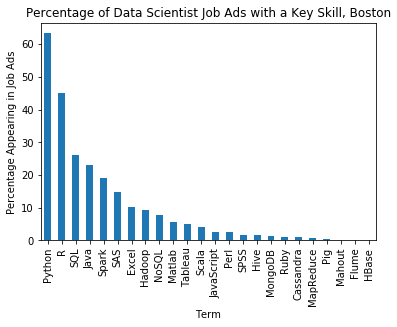

In [42]:
boston_info = skills_info(city = 'Boston', state = 'MA')